# 【9】2008.1-2021.9年的来澳旅客海路人次（全部数据建模）

## 0.1-导入包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model as smt2
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

## 0.2-绘制时序图、ACF、PACF图（statsmodels自带的函数）

In [2]:
def drawts(y,pname,Type,notes,mylag=36):
    ##draw ax
    fig = plt.figure(figsize=(15,12))
    ts_ax=plt.subplot2grid((2,2),(0,0),colspan=2)
    acf_ax=plt.subplot2grid((2,2),(1,0))
    pacf_ax=plt.subplot2grid((2,2),(1,1))
    ##draw plot
    ts_ax.plot(y,'*-')
    smt.graphics.plot_acf(y,lags=mylag,ax=acf_ax,alpha=0.05) ##2sigma
    smt.graphics.plot_pacf(y,lags=mylag,ax=pacf_ax,alpha=0.05)  ##2sigma
    #plt.savefig('%s.jpg'%pname,dpi=256)
    
    # plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['font.size'] = '15'
    plt.rcParams['axes.unicode_minus'] = False
    
    fig.suptitle("Time Series Analysis Plots of %s by %s"%(notes,Type),fontsize = 20)
    ts_ax.set_title('Sequence Chart')
    ts_ax.set_xlabel("Time(months)")
    ts_ax.set_ylabel("Number of %s passengers(person)"%Type)
    acf_ax.set_xlabel("number of lags(period)")
    acf_ax.set_ylabel("correlation")
    pacf_ax.set_xlabel("number of lags(period)")
    pacf_ax.set_ylabel("correlation")
    plt.savefig("Time Series Analysis Plots of %s by %s.jpg"%(notes,Type),dpi=256)
    plt.show()
    plt.close()

## 0.3-LB统计量（statsmodels自带的LB test函数）

In [3]:
def purerandtest(y,mylag=24):
    a,b=lb_test(y,lags=mylag,boxpierce=False)
    LB_purerand=pd.DataFrame(np.c_[a,b],columns=['LB','Pvalue'])
    LB_purerand['lags']=range(1,len(a)+1)
    print('----time series: LB pure randomness test----')
    print(LB_purerand)

## 0.4-绘图（真实值+拟合值+预测值）

In [4]:
def plot_all(y,mypred,Type):
    mylen=len(y)
    plt.figure(figsize=(24,12))         # 设置画布大小
    plt.plot(y,'-',label='observe')                                # 真实值
    startdraw=20
    plt.plot(np.arange(startdraw,mypred.predicted_mean.shape[0]),mypred.predicted_mean[startdraw:],'-*',label='fit')
    plt.plot(np.arange(mylen,mypred.predicted_mean.shape[0]),mypred.predicted_mean[mylen:],'-*',label='predict')

    plt.fill_between(np.arange(startdraw,mypred.predicted_mean.shape[0]),
                 mypred.conf_int(0.05)[startdraw:,0],
                 mypred.conf_int(0.05)[startdraw:,1],
                 color='lightblue')                    # 绘制置信区间
    plt.rcParams['font.size'] = '15'
    plt.legend()                                          # 添加图例
    plt.xlabel("Time(months)")                            # xlabel 
    plt.ylabel("Number of %s passengers(person)"%Type)    # ylabel
    plt.title('%s\'s fitted and predictive value'%Type,fontsize = 20)   # 添加标题
    plt.savefig('%s\'s fitted and predictive value.jpg'%Type,dpi=256)
    plt.show()                                            # 显示图像
    plt.close()                                           # 关闭图像

## 0.5-模型比较定阶

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from statsmodels.tsa.arima_model import ARIMA
import warnings
# 忽视在模型拟合中遇到的错误
warnings.filterwarnings("ignore")
# 找最优的参数 SARIMAX
def find_best_params(data:np.array, params_list,m):
    result = []
    best_bic= 100000
    for param in tqdm_notebook(params_list):
        # 模型拟合
        # model = SARIMAX(data,order=(param[0], param[1], param[2]),seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        model = SARIMAX(data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        bicc = model.bic # 拟合出模型的BIC值
        # print(bic)
        # 寻找最优的参数
        if bicc < best_bic:
            best_mode = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0], param[1], param[2])
        param_2 = (param[3], param[4], param[5], m)
        param = 'SARIMA{0}x{1}'.format(param_1, param_2)
        print(param)
        result.append([param,model.aic, model.bic])

    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters','AIC', 'BIC']
    result_table = result_table.sort_values(by='BIC',ascending=True).reset_index(drop=True)
    return result_table

## 1-时序图

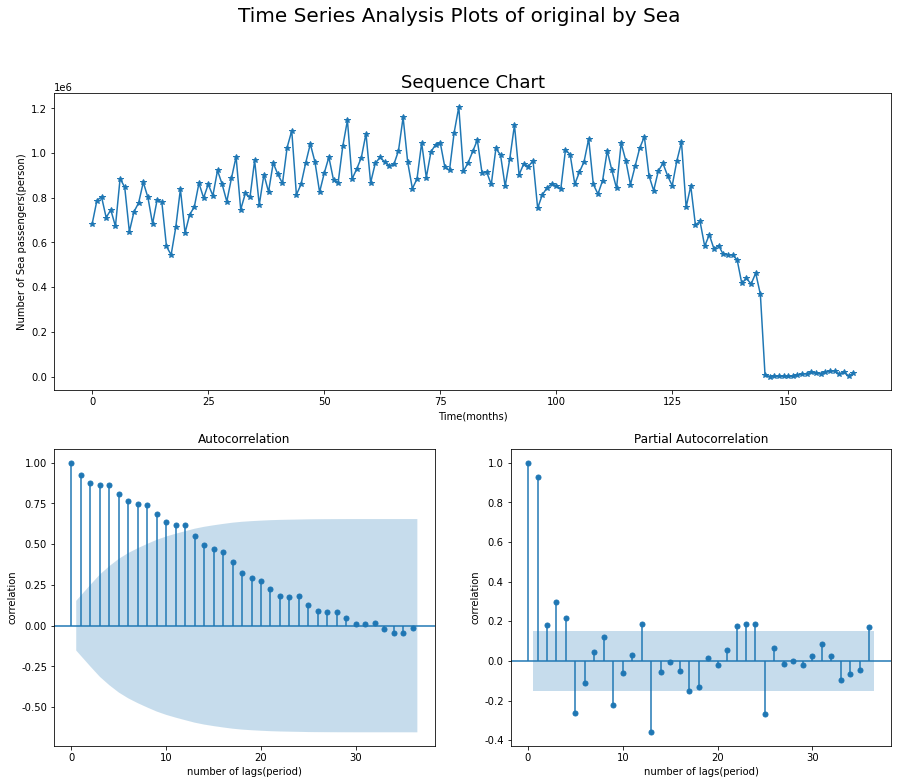

In [6]:
## read data
dfname='按入境渠道统计之来澳旅客海路人次'
Type = 'Sea'
y=pd.read_excel('%s.xlsx'%dfname,header=None)
y.iloc[:,1]=y.iloc[:,1]
y=y.values[:,1].astype('float')

## fill data
yy = pd.DataFrame(y)     # 数据转换为DataFrame类型
y = yy.interpolate().values[:,0]     # 线性插值 填补海路数据的时间序列缺失项

## plot figure
notes = 'original'      # 原始序列
drawts(y,dfname,Type,notes)

## 2-差分运算：使序列平稳化
### 2.1-判断是否是异方差

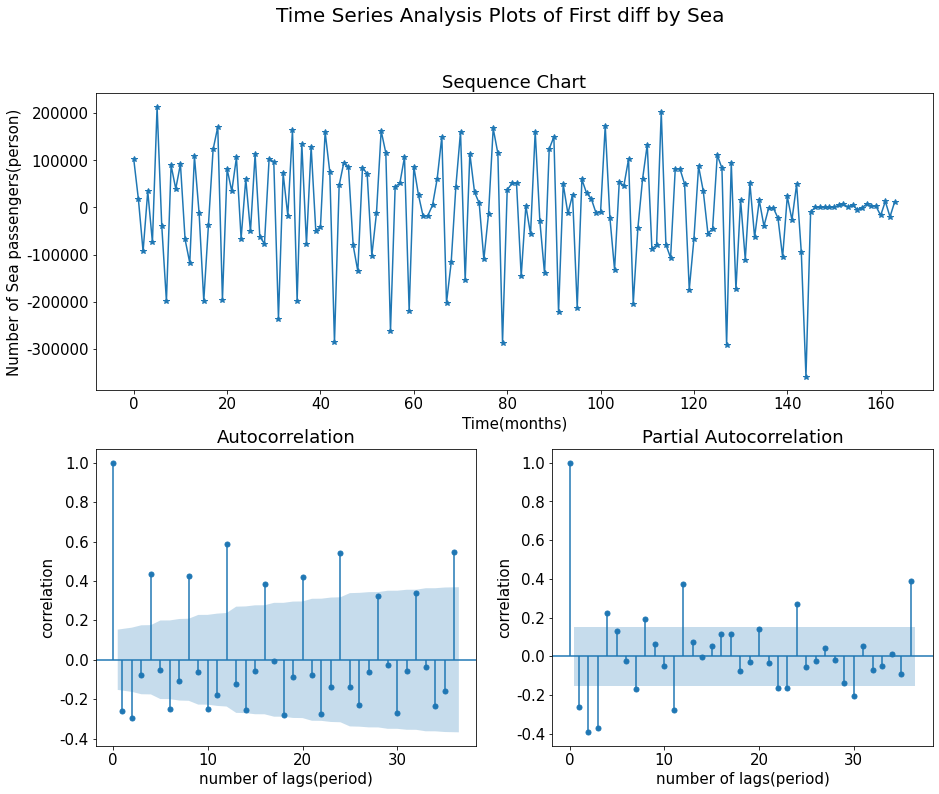

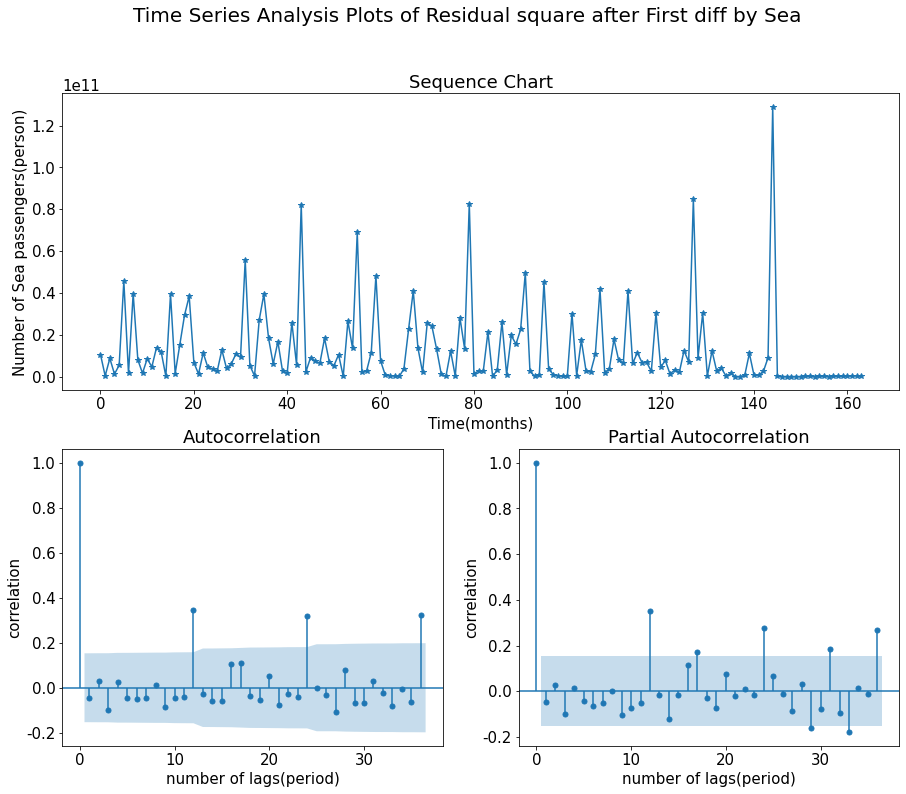

In [7]:
## 一阶差分
yd=y[1:]-y[:-1]
notes = 'First diff'    # 一阶差分
drawts(yd,dfname,Type,notes)

## 一阶差分后的残差平方图
notes = 'Residual square after First diff'    # 一阶差分后的残差平方图
drawts(yd**2,dfname,Type,notes)

### 2.2-方差齐性变换
$$  y_t=log(x_t)  $$

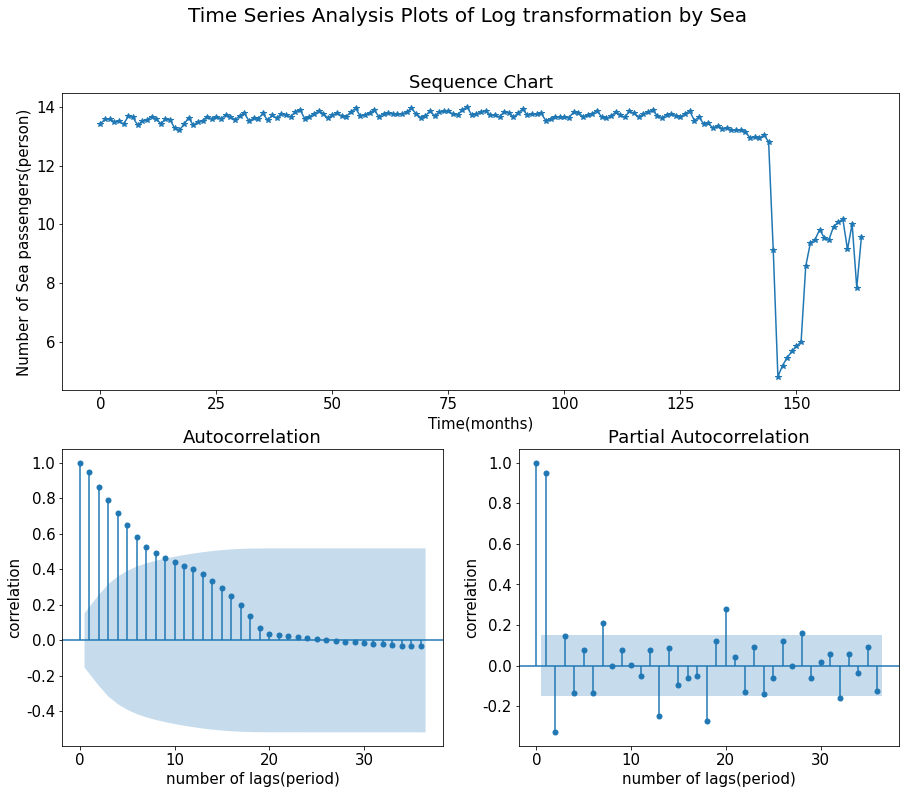

In [8]:
## 对数变换
newy=np.log(y)
notes = 'Log transformation'   # 对数变换后
drawts(newy,dfname,Type,notes)

### 2.3-对数变换后一阶差分

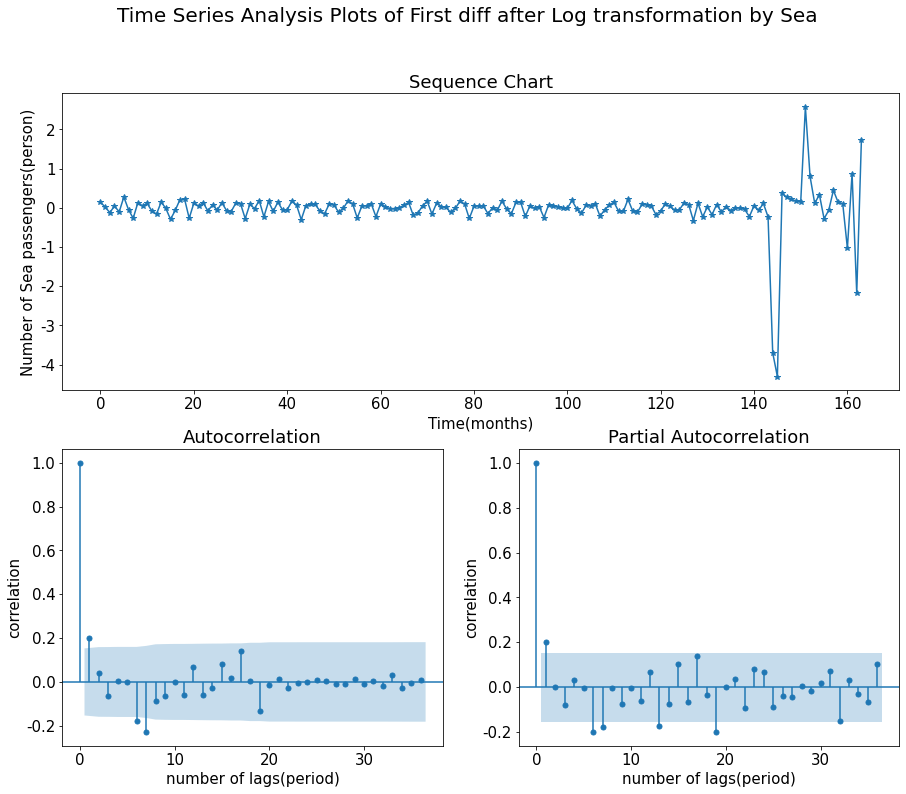

In [9]:
## 一阶差分
yd=newy[1:]-newy[:-1]
notes = 'First diff after Log transformation'   # 对数变换后一阶差分
drawts(yd,dfname,Type,notes)

## 12步差分
#yd=yd[12:]-yd[:-12]
#drawts(yd,dfname)


## 3-白噪声检验

In [10]:
purerandtest(yd)

----time series: LB pure randomness test----
           LB    Pvalue  lags
0    6.587534  0.010270     1
1    6.877207  0.032109     2
2    7.590798  0.055271     3
3    7.592361  0.107705     4
4    7.592376  0.180178     5
5   13.043891  0.042344     6
6   22.209596  0.002337     7
7   23.594389  0.002679     8
8   24.330564  0.003808     9
9   24.330943  0.006769    10
10  24.976291  0.009190    11
11  25.780571  0.011528    12
12  26.394731  0.015040    13
13  26.553483  0.021993    14
14  27.799707  0.022857    15
15  27.845764  0.032987    16
16  31.553424  0.017089    17
17  31.554431  0.024812    18
18  34.829323  0.014643    19
19  34.857801  0.020875    20
20  34.895854  0.028987    21
21  35.054775  0.038238    22
22  35.061316  0.051291    23
23  35.061488  0.067494    24


- 差分后LB统计量对应的6、12期的P值<0.05，是非白噪声序列

## 4-建模，参数估计

### 4.1-模型定阶

In [11]:
from itertools import product
# ARIMA的参数
ps = range(1, 4)
d = range(1, 2)
qs = range(1, 4)
# 季节项相关的参数
Ps = range(0, 1)
D = range(0, 1)
Qs = range(0, 1)
m = 0
# 将参数打包，传入下面的数据，是哦那个BIC准则进行参数选择
params_list = list(product(ps, d, qs, Ps, D, Qs))

result_table = find_best_params(newy, params_list,m)
print(result_table)

SARIMA(1, 1, 1)x(0, 0, 0, 0)
SARIMA(1, 1, 2)x(0, 0, 0, 0)
SARIMA(1, 1, 3)x(0, 0, 0, 0)
SARIMA(2, 1, 1)x(0, 0, 0, 0)
SARIMA(2, 1, 2)x(0, 0, 0, 0)
SARIMA(2, 1, 3)x(0, 0, 0, 0)
SARIMA(3, 1, 1)x(0, 0, 0, 0)
SARIMA(3, 1, 2)x(0, 0, 0, 0)
SARIMA(3, 1, 3)x(0, 0, 0, 0)

                     parameters         AIC         BIC
0  SARIMA(2, 1, 2)x(0, 0, 0, 0)  264.762182  280.261514
1  SARIMA(3, 1, 2)x(0, 0, 0, 0)  265.989215  284.588414
2  SARIMA(1, 1, 1)x(0, 0, 0, 0)  276.775640  286.075240
3  SARIMA(2, 1, 1)x(0, 0, 0, 0)  274.686941  287.086407
4  SARIMA(3, 1, 3)x(0, 0, 0, 0)  266.594783  288.293848
5  SARIMA(1, 1, 2)x(0, 0, 0, 0)  277.458117  289.857582
6  SARIMA(1, 1, 3)x(0, 0, 0, 0)  276.056094  291.555426
7  SARIMA(3, 1, 1)x(0, 0, 0, 0)  279.710681  295.210013
8  SARIMA(2, 1, 3)x(0, 0, 0, 0)  277.789535  296.388733


### 4.2-使用$SARIMA(p,d,q)(P,D,Q)_m$建模

$$
(1-\phi_1B-...-\phi_pB^p)(1-\Phi_1B-...-\Phi_pB^{Pm})(1-B^m)^D(1-B)^dx_t=(1-\theta_1B-...-\theta_qB^q)(1-\Theta_1B-...-\Theta_QB^{Qm})\varepsilon_t
$$

In [12]:
## SARIMA 
arma10=smt2.ARIMA(newy,order=(2,1,1),seasonal_order=(0,0,0,0),trend='n').fit() #trend=n,c,t,ct
print('----fitting summary----')
print(arma10.summary())

----fitting summary----
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  165
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -133.343
Date:                Fri, 03 Dec 2021   AIC                            274.687
Time:                        12:19:35   BIC                            287.086
Sample:                             0   HQIC                           279.721
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1436      0.056     20.319      0.000       1.033       1.254
ar.L2         -0.2564      0.034     -7.458      0.000      -0.324      -0.189
ma.L1         -0.9390      0

## 5-模型显著性检验（残差检验）

In [13]:
resid=arma10.resid
print('\n----residual pure randomness test')
purerandtest(resid)


----residual pure randomness test
----time series: LB pure randomness test----
          LB    Pvalue  lags
0   0.010273  0.919269     1
1   0.021151  0.989480     2
2   0.041407  0.997787     3
3   0.087512  0.999070     4
4   0.111853  0.999786     5
5   0.112559  0.999972     6
6   0.331409  0.999860     7
7   0.355759  0.999964     8
8   0.361006  0.999993     9
9   0.393833  0.999998    10
10  0.406426  1.000000    11
11  0.480089  1.000000    12
12  0.515043  1.000000    13
13  0.523314  1.000000    14
14  0.599722  1.000000    15
15  0.701094  1.000000    16
16  0.913882  1.000000    17
17  0.974329  1.000000    18
18  1.087333  1.000000    19
19  1.172770  1.000000    20
20  1.223661  1.000000    21
21  1.229729  1.000000    22
22  1.240942  1.000000    23
23  1.247198  1.000000    24


- 残差序列在6、12期的LB统计量对应的P值>0.05，显著，残差序列为白噪声序列，即拟合模型显著有效

## 6-拟合+7-预测

In [14]:
myalpha=0.05
mypred=arma10.get_prediction(start=1,end=len(y)+12,dynamic=False)  ##if True, start >0

## 
mypred.predicted_mean[:]=np.exp(mypred.predicted_mean[:])
mypred.conf_int(0.05)[:,:]=np.exp(mypred.conf_int(0.05)[:,:])

## fitted
print('\n----fitted confidence interval: %d %%'%((1-myalpha)*100))
print(mypred.summary_frame(alpha=myalpha))


----fitted confidence interval: 95 %
y             mean   mean_se  mean_ci_lower  mean_ci_upper
0    684854.633220  0.565359  684853.525136  684855.741304
1    811488.459980  0.552103  811487.377878  811489.542081
2    802002.607606  0.551133  802001.527406  802003.687806
3    686253.454797  0.550315  686252.376199  686254.533394
4    752412.662322  0.549622  752411.585083  752413.739561
..             ...       ...            ...            ...
172   25895.117392  1.641024   25891.901043   25898.333740
173   25689.467588  1.689885   25686.155475   25692.779701
174   25518.331606  1.733351   25514.934300   25521.728913
175   25375.840508  1.772597   25372.366281   25379.314734
176   25257.109496  1.808493   25253.564915   25260.654078

[177 rows x 4 columns]


## 8-绘图

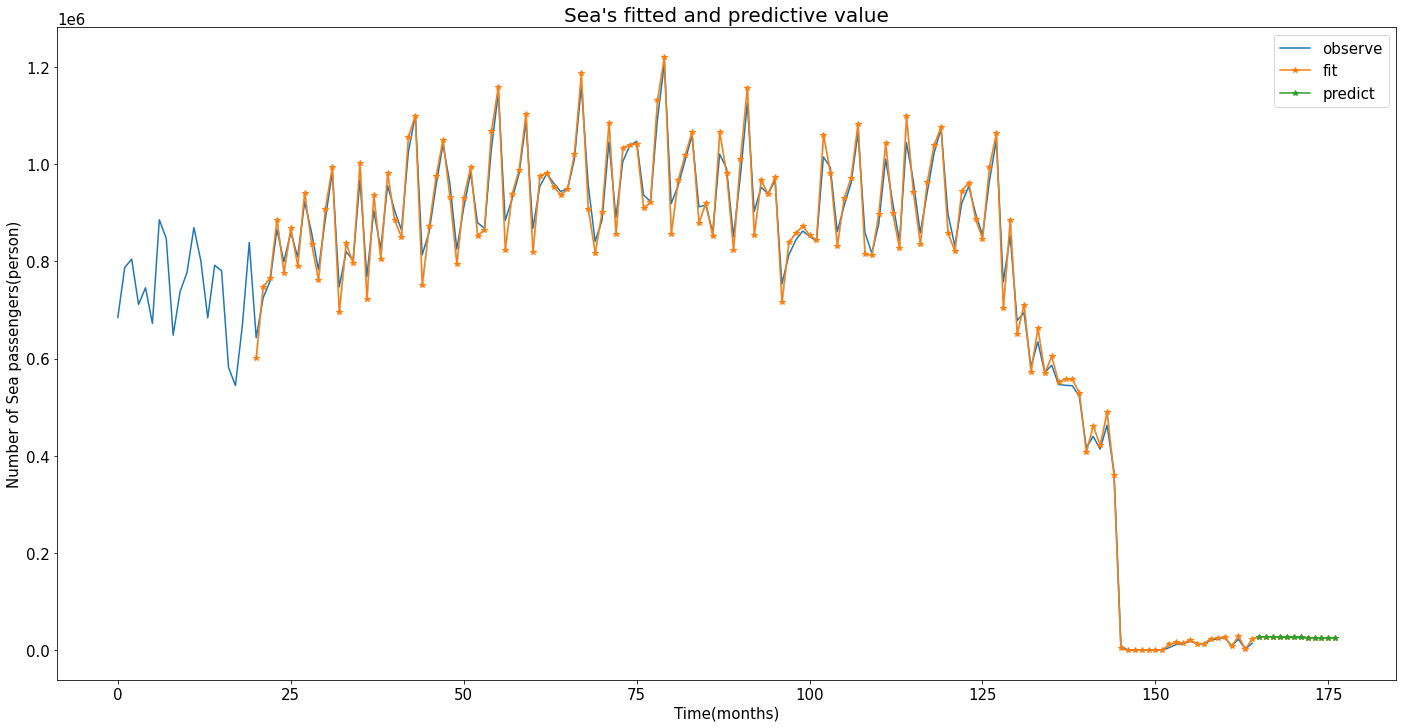

In [15]:
plot_all(y,mypred,Type)

## 9-模型评价
### 9.1-决定系数$R^2$

In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score  # 均方误差、平均绝对误差、决定系数
#TSS = sum((y[20:len(y)]-np.mean(y[20:len(y)]))**2)
#RSS = sum((mypred.predicted_mean[20:len(y)]-y[20:len(y)])**2)
#R2 = 1-RSS/TSS
#print(R2)
startdraw=20
r2 = r2_score(y[startdraw:len(y)],mypred.predicted_mean[startdraw:len(y)])
print(r2)

0.9949016713000883


### 9.2-均方根误差$RMSE$

In [17]:
rmse = np.sqrt(mean_squared_error(mypred.predicted_mean[startdraw:len(y)], y[startdraw:len(y)]))  # 均方根误差
print(rmse)

23891.383642264056


### 9.3-平均绝对误差$MAE$

In [18]:
mae = mean_absolute_error(mypred.predicted_mean[startdraw:len(y)], y[startdraw:len(y)])
print(mae)

18500.362732999798
